In [1]:
# This notebook takes the input dataset, finds quartiles for the medical interventions (IV in, max vaso in)
# for each block.
# We then discretise actions in the original dataset according to what bin they fall in, and then save 
# a new dataframe with the discretised actions.

# Source: https://github.com/MLD3/RL-Set-Valued-Policy/tree/master/mimic-sepsis/mimic_sepsis_rl/1_preprocess

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from pandas import DataFrame

## Continue processing

In [4]:
orig_data_full = pd.read_csv("path/to/MIMICtable.csv")

In [5]:
df_cohort = pd.read_csv('path/to/sepsis_mimiciii.csv')

In [6]:
icustays = df_cohort['icustayid'].unique() - 200000

In [7]:
orig_data = orig_data_full[orig_data_full['icustayid'].isin(icustays)]

In [8]:
orig_data['icustayid'].nunique()

20954

In [9]:
orig_data.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_4hourly,output_total,output_4hourly,cumulated_balance,SOFA,SIRS
0,1,3,7245486000,0,17639.826435,0,0,0,0,1,...,279.999989,0.0,0.0,6527.0,50.0,13617.0,520.0,-7090.0,4,1
1,2,3,7245500400,0,17639.826435,0,0,0,0,1,...,168.000000,0.0,0.0,6577.0,50.0,13982.0,365.0,-7405.0,6,2
2,3,3,7245514800,0,17639.826435,0,0,0,0,1,...,279.999989,0.0,0.0,6627.0,50.0,14262.0,280.0,-7635.0,5,2
3,4,3,7245529200,0,17639.826435,0,0,0,0,1,...,279.999989,0.0,0.0,6677.0,50.0,14602.0,340.0,-7925.0,5,1
4,5,3,7245543600,0,17639.826435,0,0,0,0,1,...,279.999989,0.0,0.0,6727.0,50.0,15142.0,540.0,-8415.0,5,2


In [10]:
df_icustays = orig_data.drop_duplicates('icustayid', keep='last').copy()[[
    'bloc', 'icustayid', 'charttime', 'gender', 'age', 'elixhauser',
       're_admission', 'died_in_hosp', 'died_within_48h_of_out_time',
       'mortality_90d', 'delay_end_of_record_and_discharge_or_death',
]]

In [11]:
df_icustays['age'] = df_icustays['age'] / 365.25
df_icustays['los'] = df_icustays['bloc'] * 4

In [12]:
df_icustays.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,delay_end_of_record_and_discharge_or_death,los
6,9,3,7245601200,0,48.295213,0,0,0,0,1,326.666667,36
18,12,11,6898399800,1,84.232906,6,1,0,0,0,0.800000,48
22,4,12,5805775200,1,32.988959,0,0,0,0,0,0.416667,16
32,10,14,4264398900,0,84.728186,2,0,0,0,1,70.766667,40
52,20,30,5708098800,0,54.191893,6,0,0,0,0,372.916667,80


In [13]:
df_stats1 = df_icustays.groupby('died_in_hosp')[['gender', 'age', 'los']].mean()
df_stats2 = df_icustays.groupby('died_in_hosp')[['icustayid']].count()
df_stats1 = df_stats1.rename(columns={'gender': '% Female', 'age': 'Mean Age', 'los': 'Hours in ICU'})
df_stats2 = df_stats2.rename(columns={'icustayid': 'N'})
df_stats = df_stats2.join(df_stats1)
df_stats = df_stats.reset_index()
df_stats = df_stats.rename(columns={'died_in_hosp': 'Survivors'})
df_stats['Survivors'] = df_stats['Survivors'].apply(lambda x: 'Survivors' if x==0 else 'Non-survivors')
df_stats

,Survivors,N,% Female,Mean Age,Hours in ICU
0,Survivors,18066,0.444647,64.075207,56.566146
1,Non-survivors,2888,0.429017,68.825493,60.939058


In [14]:
print(
    df_stats.to_latex(index=False, formatters=[
        lambda s: s,
        lambda s: '{}'.format(s),
        lambda s: '{0:.1%}'.format(s),
        lambda s: '{:.1f}'.format(s),
        lambda s: '{:.1f}'.format(s),
    ])
)

\begin{tabular}{lrrrr}
\toprule
     Survivors &     N & \% Female & Mean Age & Hours in ICU \\
\midrule
     Survivors & 18066 &    44.5\% &     64.1 &         56.6 \\
 Non-survivors &  2888 &    42.9\% &     68.8 &         60.9 \\
\bottomrule
\end{tabular}



## Start processing interventions

In [15]:
import copy

In [16]:
disc_inp_data = copy.deepcopy(orig_data)

In [17]:
# assume we're using input_4hourly and max_dose_vaso as the input params for now
interventions = orig_data[["max_dose_vaso", "input_4hourly"]]

In [18]:
interventions.head(5)

,max_dose_vaso,input_4hourly
0,0.0,50.0
1,0.0,50.0
2,0.0,50.0
3,0.0,50.0
4,0.0,50.0


## Original action space
based on quartiles: [0, <Q1, Q1-Q2, Q2-Q3, >Q3]

In [19]:
# only compute quartiles on nonzero values
adjusted_vaso = interventions["max_dose_vaso"][interventions["max_dose_vaso"]>0]
adjusted_iv = interventions["input_4hourly"][interventions["input_4hourly"]>0]

In [20]:
vaso_quartiles = adjusted_vaso.quantile([0.25,0.50,0.75])
iv_quartiles = adjusted_iv.quantile([0.25,0.5,0.75])

In [21]:
vq = np.array(vaso_quartiles)
vq

array([0.08, 0.2 , 0.45])

In [22]:
ivq = np.array(iv_quartiles)
ivq

array([ 48., 150., 500.])

In [24]:
discretised_int = copy.deepcopy(interventions)

In [25]:
discretised_int['vaso_input'] = discretised_int['max_dose_vaso'].astype(int)
discretised_int.loc[(interventions['max_dose_vaso'] == 0.0  ), 'vaso_input'] = 0
discretised_int.loc[(interventions['max_dose_vaso'] >  0.0  ) & (interventions['max_dose_vaso'] < vq[0]), 'vaso_input',] = 1
discretised_int.loc[(interventions['max_dose_vaso'] >= vq[0]) & (interventions['max_dose_vaso'] < vq[1]), 'vaso_input',] = 2
discretised_int.loc[(interventions['max_dose_vaso'] >= vq[1]) & (interventions['max_dose_vaso'] < vq[2]), 'vaso_input',] = 3
discretised_int.loc[(interventions['max_dose_vaso'] >= vq[2]), 'vaso_input'] = 4

In [26]:
discretised_int['iv_input'] = discretised_int['input_4hourly'].astype(int)
discretised_int.loc[(interventions['input_4hourly'] == 0.0  ), 'iv_input'] = 0
discretised_int.loc[(interventions['input_4hourly'] >  0.0  )  & (interventions['input_4hourly'] < ivq[0]), 'iv_input'] = 1
discretised_int.loc[(interventions['input_4hourly'] >= ivq[0]) & (interventions['input_4hourly'] < ivq[1]), 'iv_input'] = 2
discretised_int.loc[(interventions['input_4hourly'] >= ivq[1]) & (interventions['input_4hourly'] < ivq[2]), 'iv_input'] = 3
discretised_int.loc[(interventions['input_4hourly'] >= ivq[2]), 'iv_input'] = 4

<AxesSubplot:ylabel='Frequency'>

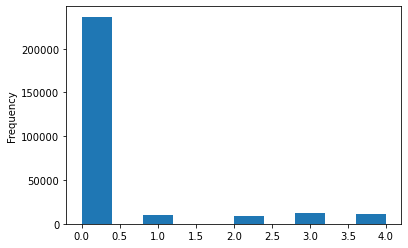

In [27]:
discretised_int['vaso_input'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

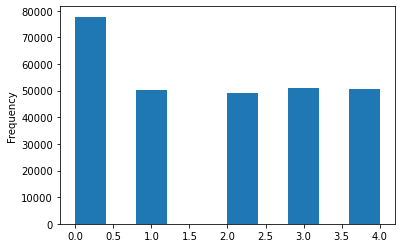

In [28]:
discretised_int['iv_input'].plot.hist()

In [29]:
disc_inp_data['vaso_input'] = discretised_int['vaso_input']
disc_inp_data['iv_input'] = discretised_int['iv_input']

## Modified action space
more clinically meaningful IV fluid doses: [0, <500mL, 500mL-1L, 1-2L, >2L]

In [30]:
# only compute quartiles on nonzero values
adjusted_vaso = interventions["max_dose_vaso"][interventions["max_dose_vaso"]>0]
adjusted_iv = interventions["input_4hourly"][interventions["input_4hourly"]>0]

In [31]:
vaso_quartiles = adjusted_vaso.quantile([0.25,0.50,0.75])
iv_quartiles = adjusted_iv.quantile([0.25,0.5,0.75])

In [32]:
vq = np.array(vaso_quartiles)
vq

array([0.08, 0.2 , 0.45])

In [33]:
# change fluids range to be more clinically relevant
ivq  = np.array([500, 1000, 2000])
ivq

array([ 500, 1000, 2000])

In [34]:
discretised_int = copy.deepcopy(interventions)

In [35]:
discretised_int['vaso_input'] = discretised_int['max_dose_vaso'].astype(int)
discretised_int.loc[(interventions['max_dose_vaso'] == 0.0  ), 'vaso_input'] = 0
discretised_int.loc[(interventions['max_dose_vaso'] >  0.0  ) & (interventions['max_dose_vaso'] < vq[0]), 'vaso_input'] = 1
discretised_int.loc[(interventions['max_dose_vaso'] >= vq[0]) & (interventions['max_dose_vaso'] < vq[1]), 'vaso_input'] = 2
discretised_int.loc[(interventions['max_dose_vaso'] >= vq[1]) & (interventions['max_dose_vaso'] < vq[2]), 'vaso_input'] = 3
discretised_int.loc[(interventions['max_dose_vaso'] >= vq[2]), 'vaso_input'] = 4

In [36]:
discretised_int['iv_input'] = discretised_int['input_4hourly'].astype(int)
discretised_int.loc[(interventions['input_4hourly'] == 0.0  ), 'iv_input'] = 0
discretised_int.loc[(interventions['input_4hourly'] >  0.0  )  & (interventions['input_4hourly'] < ivq[0]), 'iv_input'] = 1
discretised_int.loc[(interventions['input_4hourly'] >= ivq[0]) & (interventions['input_4hourly'] < ivq[1]), 'iv_input'] = 2
discretised_int.loc[(interventions['input_4hourly'] >= ivq[1]) & (interventions['input_4hourly'] < ivq[2]), 'iv_input'] = 3
discretised_int.loc[(interventions['input_4hourly'] >= ivq[2]), 'iv_input'] = 4

<AxesSubplot:ylabel='Frequency'>

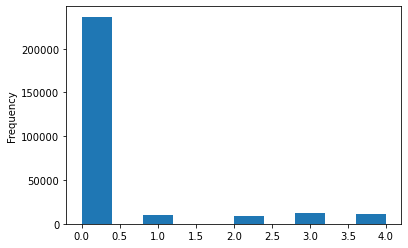

In [37]:
discretised_int['vaso_input'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

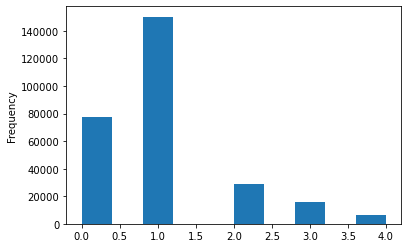

In [38]:
discretised_int['iv_input'].plot.hist()

In [39]:
disc_inp_data['vaso_input_NEW'] = discretised_int['vaso_input']
disc_inp_data['iv_input_NEW'] = discretised_int['iv_input']

## Done.

In [40]:
disc_inp_data.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,input_4hourly,output_total,output_4hourly,cumulated_balance,SOFA,SIRS,vaso_input,iv_input,vaso_input_NEW,iv_input_NEW
0,1,3,7245486000,0,17639.826435,0,0,0,0,1,...,50.0,13617.0,520.0,-7090.0,4,1,0,2,0,1
1,2,3,7245500400,0,17639.826435,0,0,0,0,1,...,50.0,13982.0,365.0,-7405.0,6,2,0,2,0,1
2,3,3,7245514800,0,17639.826435,0,0,0,0,1,...,50.0,14262.0,280.0,-7635.0,5,2,0,2,0,1
3,4,3,7245529200,0,17639.826435,0,0,0,0,1,...,50.0,14602.0,340.0,-7925.0,5,1,0,2,0,1
4,5,3,7245543600,0,17639.826435,0,0,0,0,1,...,50.0,15142.0,540.0,-8415.0,5,2,0,2,0,1


In [41]:
disc_inp_data['vaso_input'].value_counts()

0    236579
3     11821
4     10835
1     10218
2      9123
Name: vaso_input, dtype: int64

In [42]:
disc_inp_data['iv_input'].value_counts()

0    77728
3    51022
4    50547
1    50066
2    49213
Name: iv_input, dtype: int64

In [43]:
disc_inp_data['vaso_input_NEW'].value_counts()

0    236579
3     11821
4     10835
1     10218
2      9123
Name: vaso_input_NEW, dtype: int64

In [44]:
disc_inp_data['iv_input_NEW'].value_counts()

1    150301
0     77728
2     28752
3     15685
4      6110
Name: iv_input_NEW, dtype: int64

In [45]:
disc_inp_data.to_csv('../data/discretised_input_data.csv', index=False)